# Sistema de Previsão de Ações Brasileiras com Redes Neurais LSTM

Este notebook implementa um sistema completo de previsão para as ações:
- **Vivara (VIVA3.SA)**
- **Movida (MOVI3.SA)** 
- **Trisul (TRIS3.SA)**

## Funcionalidades:
- Coleta de dados históricos dos últimos 5 anos
- Análise técnica completa
- Modelo LSTM para previsão de preços
- Detecção de eventos significativos (grandes altas/baixas)
- Recomendações de **COMPRAR**, **VENDER** ou **MANTER**
- Níveis de probabilidade baseados no histórico
- Análise para diferentes horizontes temporais (1 semana, 1 mês, 3 meses, 6 meses, 1 ano)

## 1. Instalação e Importação de Bibliotecas

In [1]:
# Instalar dependências necessárias
!pip install yfinance tensorflow scikit-learn plotly pandas numpy scipy matplotlib seaborn

# Importar bibliotecas
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# TensorFlow para LSTM
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sklearn para preprocessing e métricas
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from scipy.stats import norm
from scipy.signal import find_peaks

# Configurações
from datetime import datetime, timedelta
import random
np.random.seed(42)
tf.random.set_seed(42)

print("Bibliotecas importadas com sucesso!")
print(f"TensorFlow versão: {tf.__version__}")
print(f"Pandas versão: {pd.__version__}")

Bibliotecas importadas com sucesso!
TensorFlow versão: 2.19.0
Pandas versão: 2.2.3


## 2. Definição das Classes e Funções

In [4]:
class DataCollector:
    """Classe para coleta de dados históricos das ações brasileiras"""
    
    def __init__(self):
        self.stocks = ["VIVA3.SA", "MOVI3.SA", "TRIS3.SA"]
        self.stock_names = {
            "VIVA3.SA": "Vivara",
            "MOVI3.SA": "Movida", 
            "TRIS3.SA": "Trisul"
        }
    
    def get_stock_data(self, symbol, days=1825):
        """Coleta dados históricos de uma ação"""
        try:
            end_date = datetime.now()
            start_date = end_date - timedelta(days=days)
            
            ticker = yf.Ticker(symbol)
            data = ticker.history(
                start=start_date.strftime('%Y-%m-%d'),
                end=end_date.strftime('%Y-%m-%d'),
                interval='1d'
            )
            
            if data.empty:
                print(f"Nenhum dado encontrado para {symbol}")
                return None
            
            # Limpar e preparar dados
            data = self._clean_data(data)
            data = self._add_derived_columns(data)
            
            return data
            
        except Exception as e:
            print(f"Erro ao coletar dados para {symbol}: {str(e)}")
            return None
    
    def _clean_data(self, data):
        """Limpa e prepara os dados"""
        data = data.dropna()
        data = data[data['Volume'] > 0]
        
        # Remover outliers extremos
        for col in ['Open', 'High', 'Low', 'Close']:
            Q1 = data[col].quantile(0.01)
            Q3 = data[col].quantile(0.99)
            data = data[(data[col] >= Q1) & (data[col] <= Q3)]
        
        return data
    
    def _add_derived_columns(self, data):
        """Adiciona colunas derivadas aos dados"""
        # Retornos
        data['Returns'] = data['Close'].pct_change()
        data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
        
        # Volatilidade móvel
        data['Volatility'] = data['Returns'].rolling(window=20).std()
        
        # True Range para ATR
        data['TR1'] = data['High'] - data['Low']
        data['TR2'] = abs(data['High'] - data['Close'].shift(1))
        data['TR3'] = abs(data['Low'] - data['Close'].shift(1))
        data['True_Range'] = data[['TR1', 'TR2', 'TR3']].max(axis=1)
        data['ATR'] = data['True_Range'].rolling(window=14).mean()
        
        # Amplitude diária
        data['Daily_Range'] = ((data['High'] - data['Low']) / data['Close']) * 100
        
        # Gap de abertura
        data['Gap'] = ((data['Open'] - data['Close'].shift(1)) / data['Close'].shift(1)) * 100
        
        # Remover colunas temporárias
        data = data.drop(['TR1', 'TR2', 'TR3'], axis=1, errors='ignore')
        
        return data
    
    def get_multiple_stocks(self, days=1825):
        """Coleta dados para todas as ações"""
        data_dict = {}
        
        for symbol in self.stocks:
            print(f"Coletando dados para {self.stock_names[symbol]} ({symbol})...")
            data = self.get_stock_data(symbol, days)
            if data is not None:
                data_dict[symbol] = data
                print(f"✓ {len(data)} registros coletados")
            else:
                print(f"✗ Erro na coleta")
        
        return data_dict

In [5]:
class TechnicalAnalysis:
    """Classe para análise técnica de ações"""
    
    def __init__(self):
        pass
    
    def calculate_indicators(self, data):
        """Calcula todos os indicadores técnicos"""
        df = data.copy()
        
        try:
            # Médias móveis
            df = self._add_moving_averages(df)
            
            # Oscilladores
            df = self._add_oscillators(df)
            
            # Bandas de Bollinger
            df = self._add_bollinger_bands(df)
            
            # MACD
            df = self._add_macd(df)
            
            # Indicadores de volume
            df = self._add_volume_indicators(df)
            
            # Suporte e resistência
            df = self._add_support_resistance(df)
            
            # Indicadores customizados
            df = self._add_custom_indicators(df)
            
            return df
            
        except Exception as e:
            print(f"Erro no cálculo de indicadores técnicos: {str(e)}")
            return data
    
    def _add_moving_averages(self, df):
        """Adiciona médias móveis"""
        # Médias móveis simples
        df['SMA_10'] = df['Close'].rolling(window=10).mean()
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['SMA_200'] = df['Close'].rolling(window=200).mean()
        
        # Médias móveis exponenciais
        df['EMA_12'] = df['Close'].ewm(span=12).mean()
        df['EMA_26'] = df['Close'].ewm(span=26).mean()
        df['EMA_50'] = df['Close'].ewm(span=50).mean()
        
        # Posição relativa às médias
        df['Price_vs_SMA20'] = (df['Close'] - df['SMA_20']) / df['SMA_20'] * 100
        df['Price_vs_SMA50'] = (df['Close'] - df['SMA_50']) / df['SMA_50'] * 100
        
        return df
    
    def _add_oscillators(self, df):
        """Adiciona osciladores"""
        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        df['RSI_Oversold'] = df['RSI'] < 30
        df['RSI_Overbought'] = df['RSI'] > 70
        
        # Stochastic %K
        low_14 = df['Low'].rolling(window=14).min()
        high_14 = df['High'].rolling(window=14).max()
        df['Stoch_K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
        df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()
        
        # Williams %R
        df['Williams_R'] = -100 * ((high_14 - df['Close']) / (high_14 - low_14))
        
        return df
    
    def _add_bollinger_bands(self, df):
        """Adiciona Bandas de Bollinger"""
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
        df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
        
        # Posição dentro das bandas
        df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
        
        # Largura das bandas
        df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']
        
        return df
    
    def _add_macd(self, df):
        """Adiciona MACD"""
        ema12 = df['Close'].ewm(span=12).mean()
        ema26 = df['Close'].ewm(span=26).mean()
        df['MACD'] = ema12 - ema26
        df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
        
        # Sinais de cruzamento
        df['MACD_Bullish'] = (df['MACD'] > df['MACD_Signal']) & (df['MACD'].shift(1) <= df['MACD_Signal'].shift(1))
        df['MACD_Bearish'] = (df['MACD'] < df['MACD_Signal']) & (df['MACD'].shift(1) >= df['MACD_Signal'].shift(1))
        
        return df
    
    def _add_volume_indicators(self, df):
        """Adiciona indicadores de volume"""
        # Volume médio
        df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']
        
        # On Balance Volume (simplificado)
        obv = [0]
        for i in range(1, len(df)):
            if df['Close'].iloc[i] > df['Close'].iloc[i-1]:
                obv.append(obv[-1] + df['Volume'].iloc[i])
            elif df['Close'].iloc[i] < df['Close'].iloc[i-1]:
                obv.append(obv[-1] - df['Volume'].iloc[i])
            else:
                obv.append(obv[-1])
        df['OBV'] = obv
        
        return df
    
    def _add_support_resistance(self, df):
        """Identifica níveis de suporte e resistência"""
        # Usar método de pivôs locais
        high_peaks, _ = find_peaks(df['High'], distance=5)
        low_peaks, _ = find_peaks(-df['Low'], distance=5)
        
        # Inicializar colunas
        df['Resistance_Level'] = np.nan
        df['Support_Level'] = np.nan
        
        # Marcar níveis
        if len(high_peaks) > 0:
            df.iloc[high_peaks, df.columns.get_loc('Resistance_Level')] = df['High'].iloc[high_peaks]
        
        if len(low_peaks) > 0:
            df.iloc[low_peaks, df.columns.get_loc('Support_Level')] = df['Low'].iloc[low_peaks]
        
        # Preencher níveis
        df['Current_Resistance'] = df['Resistance_Level'].fillna(method='ffill')
        df['Current_Support'] = df['Support_Level'].fillna(method='ffill')
        
        return df
    
    def _add_custom_indicators(self, df):
        """Adiciona indicadores customizados"""
        # Momentum de preço
        df['Price_Momentum'] = df['Close'].pct_change(5) * 100
        
        # Volatilidade intraday
        df['Intraday_Volatility'] = ((df['High'] - df['Low']) / df['Close']) * 100
        
        # Posição de fechamento
        df['Closing_Position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])
        
        # Tendência de curto prazo
        df['Short_Trend'] = np.where(df['Close'] > df['SMA_10'], 1, 
                                   np.where(df['Close'] < df['SMA_10'], -1, 0))
        
        return df

In [6]:
class LSTMModel:
    """Classe para modelo LSTM de previsão de ações"""
    
    def __init__(self, sequence_length=60, features=None):
        self.sequence_length = sequence_length
        self.features = features or ['Close', 'Volume', 'High', 'Low', 'Open']
        self.model = None
        self.scaler = None
        
    def prepare_data(self, data):
        """Prepara os dados para treinamento do LSTM"""
        # Selecionar features disponíveis
        available_features = [f for f in self.features if f in data.columns]
        
        if not available_features:
            print("Nenhuma feature encontrada nos dados")
            return None, None, None, None, None
        
        # Preparar dados
        dataset = data[available_features].values
        
        # Normalizar dados
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(dataset)
        
        # Criar sequências
        X, y = [], []
        
        for i in range(self.sequence_length, len(scaled_data)):
            X.append(scaled_data[i-self.sequence_length:i])
            y.append(scaled_data[i, 0])  # Predizer apenas o preço de fechamento
        
        X, y = np.array(X), np.array(y)
        
        # Dividir em treino e teste (80/20)
        train_size = int(0.8 * len(X))
        
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        return X_train, y_train, X_test, y_test, scaler
    
    def build_model(self, input_shape):
        """Constrói a arquitetura do modelo LSTM"""
        model = Sequential([
            # Primeira camada LSTM
            LSTM(128, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            BatchNormalization(),
            
            # Segunda camada LSTM
            LSTM(64, return_sequences=True),
            Dropout(0.2),
            BatchNormalization(),
            
            # Terceira camada LSTM
            LSTM(32, return_sequences=False),
            Dropout(0.2),
            BatchNormalization(),
            
            # Camadas densas
            Dense(25, activation='relu'),
            Dropout(0.1),
            Dense(1, activation='linear')
        ])
        
        # Compilar modelo
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def train(self, data, stock_symbol):
        """Treina o modelo LSTM"""
        try:
            print(f"Treinando modelo LSTM para {stock_symbol}...")
            
            # Preparar dados
            X_train, y_train, X_test, y_test, scaler = self.prepare_data(data)
            
            if X_train is None:
                return None
            
            print(f"Dados de treino: {X_train.shape}, Teste: {X_test.shape}")
            
            # Construir modelo
            model = self.build_model((X_train.shape[1], X_train.shape[2]))
            
            # Callbacks
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )
            
            reduce_lr = ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=0.0001
            )
            
            # Treinamento
            history = model.fit(
                X_train, y_train,
                batch_size=32,
                epochs=50,  # Reduzido para o notebook
                validation_data=(X_test, y_test),
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )
            
            # Avaliação
            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)
            
            # Desnormalizar previsões
            train_predictions = self._denormalize_predictions(train_predictions, scaler)
            test_predictions = self._denormalize_predictions(test_predictions, scaler)
            
            # Desnormalizar valores reais
            y_train_real = self._denormalize_predictions(y_train.reshape(-1, 1), scaler)
            y_test_real = self._denormalize_predictions(y_test.reshape(-1, 1), scaler)
            
            # Calcular métricas
            train_rmse = np.sqrt(mean_squared_error(y_train_real, train_predictions))
            test_rmse = np.sqrt(mean_squared_error(y_test_real, test_predictions))
            train_mae = mean_absolute_error(y_train_real, train_predictions)
            test_mae = mean_absolute_error(y_test_real, test_predictions)
            
            # Calcular acurácia direcional
            train_accuracy = self._calculate_directional_accuracy(y_train_real, train_predictions)
            test_accuracy = self._calculate_directional_accuracy(y_test_real, test_predictions)
            
            print(f"Treinamento concluído!")
            print(f"RMSE Teste: {test_rmse:.4f}")
            print(f"MAE Teste: {test_mae:.4f}")
            print(f"Acurácia Direcional: {test_accuracy:.2f}%")
            
            self.model = model
            self.scaler = scaler
            
            return {
                'model': model,
                'scaler': scaler,
                'history': history.history,
                'metrics': {
                    'train_rmse': train_rmse,
                    'test_rmse': test_rmse,
                    'train_mae': train_mae,
                    'test_mae': test_mae,
                    'train_accuracy': train_accuracy,
                    'test_accuracy': test_accuracy
                },
                'predictions': {
                    'train': train_predictions,
                    'test': test_predictions,
                    'y_train': y_train_real,
                    'y_test': y_test_real
                }
            }
            
        except Exception as e:
            print(f"Erro no treinamento do modelo: {str(e)}")
            return None
    
    def _denormalize_predictions(self, predictions, scaler):
        """Desnormaliza as previsões"""
        dummy_array = np.zeros((len(predictions), len(self.features)))
        dummy_array[:, 0] = predictions.flatten()
        denormalized = scaler.inverse_transform(dummy_array)
        return denormalized[:, 0]
    
    def _calculate_directional_accuracy(self, y_true, y_pred):
        """Calcula a acurácia direcional das previsões"""
        if len(y_true) < 2 or len(y_pred) < 2:
            return 0.0
        
        true_direction = np.diff(y_true.flatten()) > 0
        pred_direction = np.diff(y_pred.flatten()) > 0
        accuracy = np.mean(true_direction == pred_direction) * 100
        
        return accuracy
    
    def predict_next(self, data, days=1):
        """Faz previsão para os próximos dias"""
        if self.model is None or self.scaler is None:
            print("Modelo não foi treinado ainda")
            return None
        
        try:
            available_features = [f for f in self.features if f in data.columns]
            last_data = data[available_features].tail(self.sequence_length).values
            
            # Normalizar
            last_data_scaled = self.scaler.transform(last_data)
            
            predictions = []
            current_sequence = last_data_scaled.copy()
            
            for _ in range(days):
                # Preparar entrada
                X = current_sequence[-self.sequence_length:].reshape(1, self.sequence_length, len(available_features))
                
                # Fazer previsão
                prediction = self.model.predict(X, verbose=0)[0, 0]
                predictions.append(prediction)
                
                # Atualizar sequência
                new_row = current_sequence[-1].copy()
                new_row[0] = prediction
                current_sequence = np.vstack([current_sequence, new_row])
            
            # Desnormalizar previsões
            predictions = np.array(predictions).reshape(-1, 1)
            predictions_denorm = self._denormalize_predictions(predictions, self.scaler)
            
            return predictions_denorm
            
        except Exception as e:
            print(f"Erro na previsão: {str(e)}")
            return None

In [7]:
class StockAnalyzer:
    """Classe principal para análise completa de ações"""
    
    def __init__(self):
        self.data_collector = DataCollector()
        self.technical_analysis = TechnicalAnalysis()
        self.models = {}
        
    def detect_significant_events(self, data, threshold=0.05):
        """Detecta eventos significativos nos preços"""
        events = []
        
        try:
            returns = data['Close'].pct_change().dropna()
            significant_moves = abs(returns) > threshold
            significant_dates = returns[significant_moves]
            
            for date, return_val in significant_dates.items():
                if return_val > threshold:
                    event_type = "Alta Significativa"
                    description = f"Valorização de {return_val*100:.2f}%"
                else:
                    event_type = "Queda Significativa"
                    description = f"Desvalorização de {abs(return_val)*100:.2f}%"
                
                # Analisar volume
                volume_ratio = self._get_volume_ratio(data, date)
                cause = self._identify_potential_cause(return_val, volume_ratio, data, date)
                
                events.append({
                    'date': date,
                    'type': event_type,
                    'magnitude': abs(return_val) * 100,
                    'description': description,
                    'potential_cause': cause,
                    'volume_ratio': volume_ratio
                })
            
            events.sort(key=lambda x: x['date'], reverse=True)
            return events[:10]
            
        except Exception as e:
            print(f"Erro na detecção de eventos: {str(e)}")
            return []
    
    def _get_volume_ratio(self, data, date):
        """Calcula razão do volume vs média"""
        try:
            if date not in data.index:
                return 1.0
            
            current_volume = data.loc[date, 'Volume']
            avg_volume = data['Volume'].rolling(20).mean().loc[date]
            
            return current_volume / avg_volume if avg_volume > 0 else 1.0
        except:
            return 1.0
    
    def _identify_potential_cause(self, return_val, volume_ratio, data, date):
        """Identifica possível causa do movimento"""
        causes = []
        
        if volume_ratio > 2:
            causes.append("Volume excepcional")
        
        try:
            if date in data.index:
                date_idx = data.index.get_loc(date)
                if date_idx > 0:
                    prev_close = data['Close'].iloc[date_idx - 1]
                    current_open = data['Open'].iloc[date_idx]
                    gap = abs(current_open - prev_close) / prev_close
                    
                    if gap > 0.02:
                        causes.append("Gap de abertura")
        except:
            pass
        
        if not causes:
            if abs(return_val) > 0.07:
                causes.append("Movimento excepcional")
            else:
                causes.append("Volatilidade normal do mercado")
        
        return "; ".join(causes)
    
    def generate_recommendation(self, data, predicted_prices, horizon_days, confidence):
        """Gera recomendação de compra/venda/manter"""
        current_price = data['Close'].iloc[-1]
        predicted_price = predicted_prices[-1] if predicted_prices is not None else current_price
        
        # Mudança percentual esperada
        price_change = ((predicted_price - current_price) / current_price) * 100
        
        # Análise técnica atual
        rsi = data['RSI'].iloc[-1] if 'RSI' in data.columns else 50
        macd_signal = data['MACD'].iloc[-1] - data['MACD_Signal'].iloc[-1] if 'MACD' in data.columns else 0
        bb_position = data['BB_Position'].iloc[-1] if 'BB_Position' in data.columns else 0.5
        
        # Sistema de pontuação
        buy_score = 0
        sell_score = 0
        
        # Score baseado na previsão de preço
        if price_change > 5:
            buy_score += 3
        elif price_change > 2:
            buy_score += 2
        elif price_change > 0:
            buy_score += 1
        elif price_change < -5:
            sell_score += 3
        elif price_change < -2:
            sell_score += 2
        elif price_change < 0:
            sell_score += 1
        
        # Score baseado em indicadores técnicos
        if rsi < 30:
            buy_score += 2
        elif rsi > 70:
            sell_score += 2
        
        if macd_signal > 0:
            buy_score += 1
        elif macd_signal < 0:
            sell_score += 1
        
        if bb_position < 0.2:
            buy_score += 1
        elif bb_position > 0.8:
            sell_score += 1
        
        # Decisão final
        if buy_score > sell_score + 1:
            recommendation = 'COMPRAR'
        elif sell_score > buy_score + 1:
            recommendation = 'VENDER'
        else:
            recommendation = 'MANTER'
        
        return {
            'recommendation': recommendation,
            'confidence': confidence,
            'price_change_expected': price_change,
            'current_price': current_price,
            'predicted_price': predicted_price,
            'buy_score': buy_score,
            'sell_score': sell_score,
            'reasoning': self._generate_reasoning(data, price_change, rsi, macd_signal)
        }
    
    def _generate_reasoning(self, data, price_change, rsi, macd_signal):
        """Gera explicação para a recomendação"""
        reasoning = []
        
        if abs(price_change) > 1:
            reasoning.append(f"Modelo LSTM prevê {price_change:.1f}% de variação")
        
        if rsi > 70:
            reasoning.append("RSI indica sobrecompra")
        elif rsi < 30:
            reasoning.append("RSI indica sobrevenda")
        
        if macd_signal > 0:
            reasoning.append("MACD em sinal de alta")
        elif macd_signal < 0:
            reasoning.append("MACD em sinal de baixa")
        
        if not reasoning:
            reasoning.append("Análise baseada em múltiplos indicadores técnicos")
        
        return "; ".join(reasoning)
    
    def calculate_confidence(self, data, horizon_days):
        """Calcula nível de confiança da previsão"""
        confidence = 50.0  # Base
        
        # Fator 1: Volatilidade (menor volatilidade = maior confiança)
        volatility = data['Close'].pct_change().tail(30).std()
        volatility_factor = max(0, 20 - (volatility * 1000))
        confidence += volatility_factor
        
        # Fator 2: Volume (volume alto = maior confiança)
        current_volume = data['Volume'].iloc[-1]
        avg_volume = data['Volume'].tail(30).mean()
        volume_ratio = min(2.0, current_volume / avg_volume)
        confidence += (volume_ratio - 1) * 10
        
        # Fator 3: Convergência de indicadores
        if 'RSI' in data.columns and 'MACD' in data.columns:
            rsi = data['RSI'].iloc[-1]
            macd_signal = data['MACD'].iloc[-1] - data['MACD_Signal'].iloc[-1]
            
            rsi_signal = 1 if rsi > 50 else -1
            macd_dir = 1 if macd_signal > 0 else -1
            
            if rsi_signal == macd_dir:
                confidence += 10
        
        # Fator 4: Horizonte (menor horizonte = maior confiança)
        horizon_factor = max(0, 15 - (horizon_days / 7))
        confidence += horizon_factor
        
        # Limitar entre 10% e 95%
        confidence = max(10, min(95, confidence))
        
        return confidence

## 3. Coleta e Preparação dos Dados

In [10]:
# Inicializar analisador
analyzer = StockAnalyzer()

# Coletar dados dos últimos 5 anos para todas as ações
print("=== COLETANDO DADOS HISTÓRICOS ===")
print("Buscando dados dos últimos 5 anos...\n")

stocks_data = analyzer.data_collector.get_multiple_stocks(days=1825)

print(f"\n✓ Dados coletados para {len(stocks_data)} ações")
for stock, data in stocks_data.items():
    print(f"  - {analyzer.data_collector.stock_names[stock]}: {len(data)} registros")
    print(f"    Período: {data.index[0].strftime('%d/%m/%Y')} a {data.index[-1].strftime('%d/%m/%Y')}")

=== COLETANDO DADOS HISTÓRICOS ===
Buscando dados dos últimos 5 anos...

Coletando dados para Vivara (VIVA3.SA)...
✓ 1142 registros coletados
Coletando dados para Movida (MOVI3.SA)...
✓ 1142 registros coletados
Coletando dados para Trisul (TRIS3.SA)...
✓ 1142 registros coletados

✓ Dados coletados para 3 ações
  - Vivara: 1142 registros
    Período: 03/06/2020 a 30/05/2025
  - Movida: 1142 registros
    Período: 03/06/2020 a 30/05/2025
  - Trisul: 1142 registros
    Período: 03/06/2020 a 30/05/2025


## 4. Análise Técnica e Indicadores

In [11]:
# Aplicar análise técnica para todas as ações
print("\n=== CALCULANDO INDICADORES TÉCNICOS ===")

stocks_with_indicators = {}

for stock, data in stocks_data.items():
    print(f"\nCalculando indicadores para {analyzer.data_collector.stock_names[stock]}...")
    
    # Aplicar análise técnica
    data_with_indicators = analyzer.technical_analysis.calculate_indicators(data)
    stocks_with_indicators[stock] = data_with_indicators
    
    # Mostrar indicadores atuais
    current = data_with_indicators.iloc[-1]
    print(f"  Preço atual: R$ {current['Close']:.2f}")
    print(f"  RSI: {current['RSI']:.1f}")
    print(f"  MACD: {current['MACD']:.4f}")
    print(f"  Bollinger Position: {current['BB_Position']:.2f}")
    
print("\n✓ Indicadores técnicos calculados para todas as ações")


=== CALCULANDO INDICADORES TÉCNICOS ===

Calculando indicadores para Vivara...
  Preço atual: R$ 25.99
  RSI: 78.3
  MACD: 1.3195
  Bollinger Position: 0.84

Calculando indicadores para Movida...
  Preço atual: R$ 6.95
  RSI: 55.3
  MACD: 0.2020
  Bollinger Position: 0.54

Calculando indicadores para Trisul...
  Preço atual: R$ 7.79
  RSI: 71.2
  MACD: 0.3020
  Bollinger Position: 0.97

✓ Indicadores técnicos calculados para todas as ações


## 5. Detecção de Eventos Significativos

In [12]:
# Detectar eventos significativos para cada ação
print("\n=== DETECTANDO EVENTOS SIGNIFICATIVOS ===")

all_events = {}

for stock, data in stocks_with_indicators.items():
    stock_name = analyzer.data_collector.stock_names[stock]
    print(f"\n📊 {stock_name} ({stock})")
    print("-" * 50)
    
    events = analyzer.detect_significant_events(data, threshold=0.05)
    all_events[stock] = events
    
    if events:
        for i, event in enumerate(events[:5]):  # Mostrar apenas os 5 mais recentes
            print(f"{i+1}. {event['date'].strftime('%d/%m/%Y')} - {event['type']}")
            print(f"   Magnitude: {event['magnitude']:.2f}%")
            print(f"   Possível causa: {event['potential_cause']}")
            print(f"   Volume vs média: {event['volume_ratio']:.1f}x")
            print()
    else:
        print("   Nenhum evento significativo detectado")

print("\n✓ Análise de eventos concluída")


=== DETECTANDO EVENTOS SIGNIFICATIVOS ===

📊 Vivara (VIVA3.SA)
--------------------------------------------------
1. 30/01/2025 - Alta Significativa
   Magnitude: 6.23%
   Possível causa: Volatilidade normal do mercado
   Volume vs média: 1.8x

2. 23/12/2024 - Queda Significativa
   Magnitude: 6.25%
   Possível causa: Volatilidade normal do mercado
   Volume vs média: 1.1x

3. 28/11/2024 - Queda Significativa
   Magnitude: 6.01%
   Possível causa: Volatilidade normal do mercado
   Volume vs média: 1.7x

4. 04/11/2024 - Alta Significativa
   Magnitude: 5.38%
   Possível causa: Volatilidade normal do mercado
   Volume vs média: 1.2x

5. 09/08/2024 - Alta Significativa
   Magnitude: 7.38%
   Possível causa: Volume excepcional; Gap de abertura
   Volume vs média: 2.9x


📊 Movida (MOVI3.SA)
--------------------------------------------------
1. 27/05/2025 - Alta Significativa
   Magnitude: 6.44%
   Possível causa: Gap de abertura
   Volume vs média: 1.2x

2. 21/05/2025 - Queda Significativa

## 6. Treinamento dos Modelos LSTM

In [13]:
# Treinar modelos LSTM para cada ação
print("\n=== TREINAMENTO DOS MODELOS LSTM ===")

trained_models = {}

for stock, data in stocks_with_indicators.items():
    stock_name = analyzer.data_collector.stock_names[stock]
    print(f"\n🧠 Treinando modelo para {stock_name}")
    print("=" * 60)
    
    # Criar e treinar modelo LSTM
    lstm_model = LSTMModel(sequence_length=60)
    
    # Treinar modelo
    model_results = lstm_model.train(data, stock_name)
    
    if model_results:
        trained_models[stock] = {
            'model': lstm_model,
            'results': model_results
        }
        
        metrics = model_results['metrics']
        print(f"\n📈 Métricas do Modelo:")
        print(f"  RMSE Teste: {metrics['test_rmse']:.4f}")
        print(f"  MAE Teste: {metrics['test_mae']:.4f}")
        print(f"  Acurácia Direcional: {metrics['test_accuracy']:.2f}%")
    else:
        print(f"❌ Falha no treinamento do modelo para {stock_name}")

print(f"\n✓ {len(trained_models)} modelos treinados com sucesso")


=== TREINAMENTO DOS MODELOS LSTM ===

🧠 Treinando modelo para Vivara
Treinando modelo LSTM para Vivara...
Dados de treino: (865, 60, 5), Teste: (217, 60, 5)
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - loss: 0.4445 - mae: 0.5301 - val_loss: 0.1061 - val_mae: 0.2604 - learning_rate: 0.0010
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.2122 - mae: 0.3602 - val_loss: 0.0542 - val_mae: 0.1865 - learning_rate: 0.0010
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.1465 - mae: 0.3018 - val_loss: 0.0574 - val_mae: 0.1915 - learning_rate: 0.0010
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.1127 - mae: 0.2656 - val_loss: 0.0515 - val_mae: 0.1826 - learning_rate: 0.0010
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0995 - mae: 0.2514 - val_loss: 0.0466 - val_mae: 0.1878 - learning_rate: 0.0010
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0775 - mae: 0.2180 - val_loss: 0.0518 - val_mae: 0.2010 - learning_ra

## 7. Geração de Previsões e Recomendações

In [14]:
# Gerar previsões para diferentes horizontes temporais
print("\n=== GERAÇÃO DE PREVISÕES E RECOMENDAÇÕES ===")

horizons = {
    '1 semana': 7,
    '1 mês': 30,
    '3 meses': 90,
    '6 meses': 180,
    '1 ano': 365
}

all_predictions = {}

for stock, model_data in trained_models.items():
    stock_name = analyzer.data_collector.stock_names[stock]
    data = stocks_with_indicators[stock]
    lstm_model = model_data['model']
    
    print(f"\n📊 {stock_name} ({stock})")
    print("=" * 70)
    
    stock_predictions = {}
    
    for horizon_name, horizon_days in horizons.items():
        print(f"\n🔮 Previsão para {horizon_name}:")
        
        # Fazer previsão
        predicted_prices = lstm_model.predict_next(data, days=horizon_days)
        
        if predicted_prices is not None:
            # Calcular confiança
            confidence = analyzer.calculate_confidence(data, horizon_days)
            
            # Gerar recomendação
            recommendation = analyzer.generate_recommendation(
                data, predicted_prices, horizon_days, confidence
            )
            
            stock_predictions[horizon_name] = recommendation
            
            # Mostrar resultados
            current_price = recommendation['current_price']
            predicted_price = recommendation['predicted_price']
            price_change = recommendation['price_change_expected']
            
            print(f"  💰 Preço atual: R$ {current_price:.2f}")
            print(f"  🎯 Preço previsto: R$ {predicted_price:.2f}")
            print(f"  📈 Variação esperada: {price_change:+.2f}%")
            
            # Recomendação com cor
            rec = recommendation['recommendation']
            conf = recommendation['confidence']
            
            if rec == 'COMPRAR':
                emoji = "🟢"
            elif rec == 'VENDER':
                emoji = "🔴"
            else:
                emoji = "🟡"
            
            print(f"  {emoji} Recomendação: {rec}")
            print(f"  🎲 Probabilidade de acerto: {conf:.1f}%")
            print(f"  💭 Justificativa: {recommendation['reasoning']}")
        else:
            print(f"  ❌ Erro na previsão para {horizon_name}")
    
    all_predictions[stock] = stock_predictions

print("\n✓ Todas as previsões foram geradas")


=== GERAÇÃO DE PREVISÕES E RECOMENDAÇÕES ===

📊 Vivara (VIVA3.SA)

🔮 Previsão para 1 semana:
  💰 Preço atual: R$ 25.99
  🎯 Preço previsto: R$ 25.26
  📈 Variação esperada: -2.83%
  🔴 Recomendação: VENDER
  🎲 Probabilidade de acerto: 70.6%
  💭 Justificativa: Modelo LSTM prevê -2.8% de variação; RSI indica sobrecompra; MACD em sinal de alta

🔮 Previsão para 1 mês:
  💰 Preço atual: R$ 25.99
  🎯 Preço previsto: R$ 23.39
  📈 Variação esperada: -10.00%
  🔴 Recomendação: VENDER
  🎲 Probabilidade de acerto: 67.3%
  💭 Justificativa: Modelo LSTM prevê -10.0% de variação; RSI indica sobrecompra; MACD em sinal de alta

🔮 Previsão para 3 meses:
  💰 Preço atual: R$ 25.99
  🎯 Preço previsto: R$ 22.75
  📈 Variação esperada: -12.46%
  🔴 Recomendação: VENDER
  🎲 Probabilidade de acerto: 58.8%
  💭 Justificativa: Modelo LSTM prevê -12.5% de variação; RSI indica sobrecompra; MACD em sinal de alta

🔮 Previsão para 6 meses:
  💰 Preço atual: R$ 25.99
  🎯 Preço previsto: R$ 22.75
  📈 Variação esperada: -12.47%

## 8. Resumo Executivo e Recomendações Finais

In [15]:
# Criar resumo executivo
print("\n" + "=" * 80)
print("📋 RESUMO EXECUTIVO - RECOMENDAÇÕES DE INVESTIMENTO")
print("=" * 80)

# Tabela resumo
summary_data = []

for stock in trained_models.keys():
    stock_name = analyzer.data_collector.stock_names[stock]
    
    if stock in all_predictions:
        predictions = all_predictions[stock]
        
        # Pegar recomendação de 1 mês como referência
        if '1 mês' in predictions:
            ref_pred = predictions['1 mês']
            
            summary_data.append({
                'Ação': stock_name,
                'Código': stock,
                'Preço Atual (R$)': f"{ref_pred['current_price']:.2f}",
                'Recomendação 1M': ref_pred['recommendation'],
                'Variação Esperada (%)': f"{ref_pred['price_change_expected']:+.2f}",
                'Confiança (%)': f"{ref_pred['confidence']:.1f}"
            })

# Criar DataFrame para visualização
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Análise consolidada
print("\n" + "=" * 80)
print("🎯 ANÁLISE CONSOLIDADA POR HORIZONTE TEMPORAL")
print("=" * 80)

for horizon_name in horizons.keys():
    print(f"\n📅 {horizon_name.upper()}:")
    print("-" * 40)
    
    buy_count = 0
    sell_count = 0
    hold_count = 0
    
    for stock in trained_models.keys():
        if stock in all_predictions and horizon_name in all_predictions[stock]:
            rec = all_predictions[stock][horizon_name]['recommendation']
            conf = all_predictions[stock][horizon_name]['confidence']
            stock_name = analyzer.data_collector.stock_names[stock]
            
            if rec == 'COMPRAR':
                buy_count += 1
                emoji = "🟢"
            elif rec == 'VENDER':
                sell_count += 1
                emoji = "🔴"
            else:
                hold_count += 1
                emoji = "🟡"
            
            print(f"  {emoji} {stock_name}: {rec} (Confiança: {conf:.1f}%)")
    
    print(f"\n  📊 Resumo: {buy_count} COMPRAR, {hold_count} MANTER, {sell_count} VENDER")

print("\n" + "=" * 80)
print("⚠️  AVISOS IMPORTANTES")
print("=" * 80)
print("• Este sistema é apenas para fins educacionais e informativos")
print("• Não constitui aconselhamento financeiro profissional")
print("• As previsões são baseadas em dados históricos e podem não se repetir")
print("• Sempre faça sua própria pesquisa e consulte um consultor financeiro")
print("• Invista apenas o que você pode perder")
print("• Diversifique seus investimentos")

print("\n✅ Análise completa finalizada!")


📋 RESUMO EXECUTIVO - RECOMENDAÇÕES DE INVESTIMENTO
  Ação   Código Preço Atual (R$) Recomendação 1M Variação Esperada (%) Confiança (%)
Vivara VIVA3.SA            25.99          VENDER                -10.00          67.3
Movida MOVI3.SA             6.95          VENDER                -10.87          57.9
Trisul TRIS3.SA             7.79          VENDER                 -6.35          71.7

🎯 ANÁLISE CONSOLIDADA POR HORIZONTE TEMPORAL

📅 1 SEMANA:
----------------------------------------
  🔴 Vivara: VENDER (Confiança: 70.6%)
  🔴 Movida: VENDER (Confiança: 61.2%)
  🔴 Trisul: VENDER (Confiança: 75.0%)

  📊 Resumo: 0 COMPRAR, 0 MANTER, 3 VENDER

📅 1 MÊS:
----------------------------------------
  🔴 Vivara: VENDER (Confiança: 67.3%)
  🔴 Movida: VENDER (Confiança: 57.9%)
  🔴 Trisul: VENDER (Confiança: 71.7%)

  📊 Resumo: 0 COMPRAR, 0 MANTER, 3 VENDER

📅 3 MESES:
----------------------------------------
  🔴 Vivara: VENDER (Confiança: 58.8%)
  🔴 Movida: VENDER (Confiança: 49.3%)
  🔴 Trisul: VE

## 9. Visualizações dos Resultados

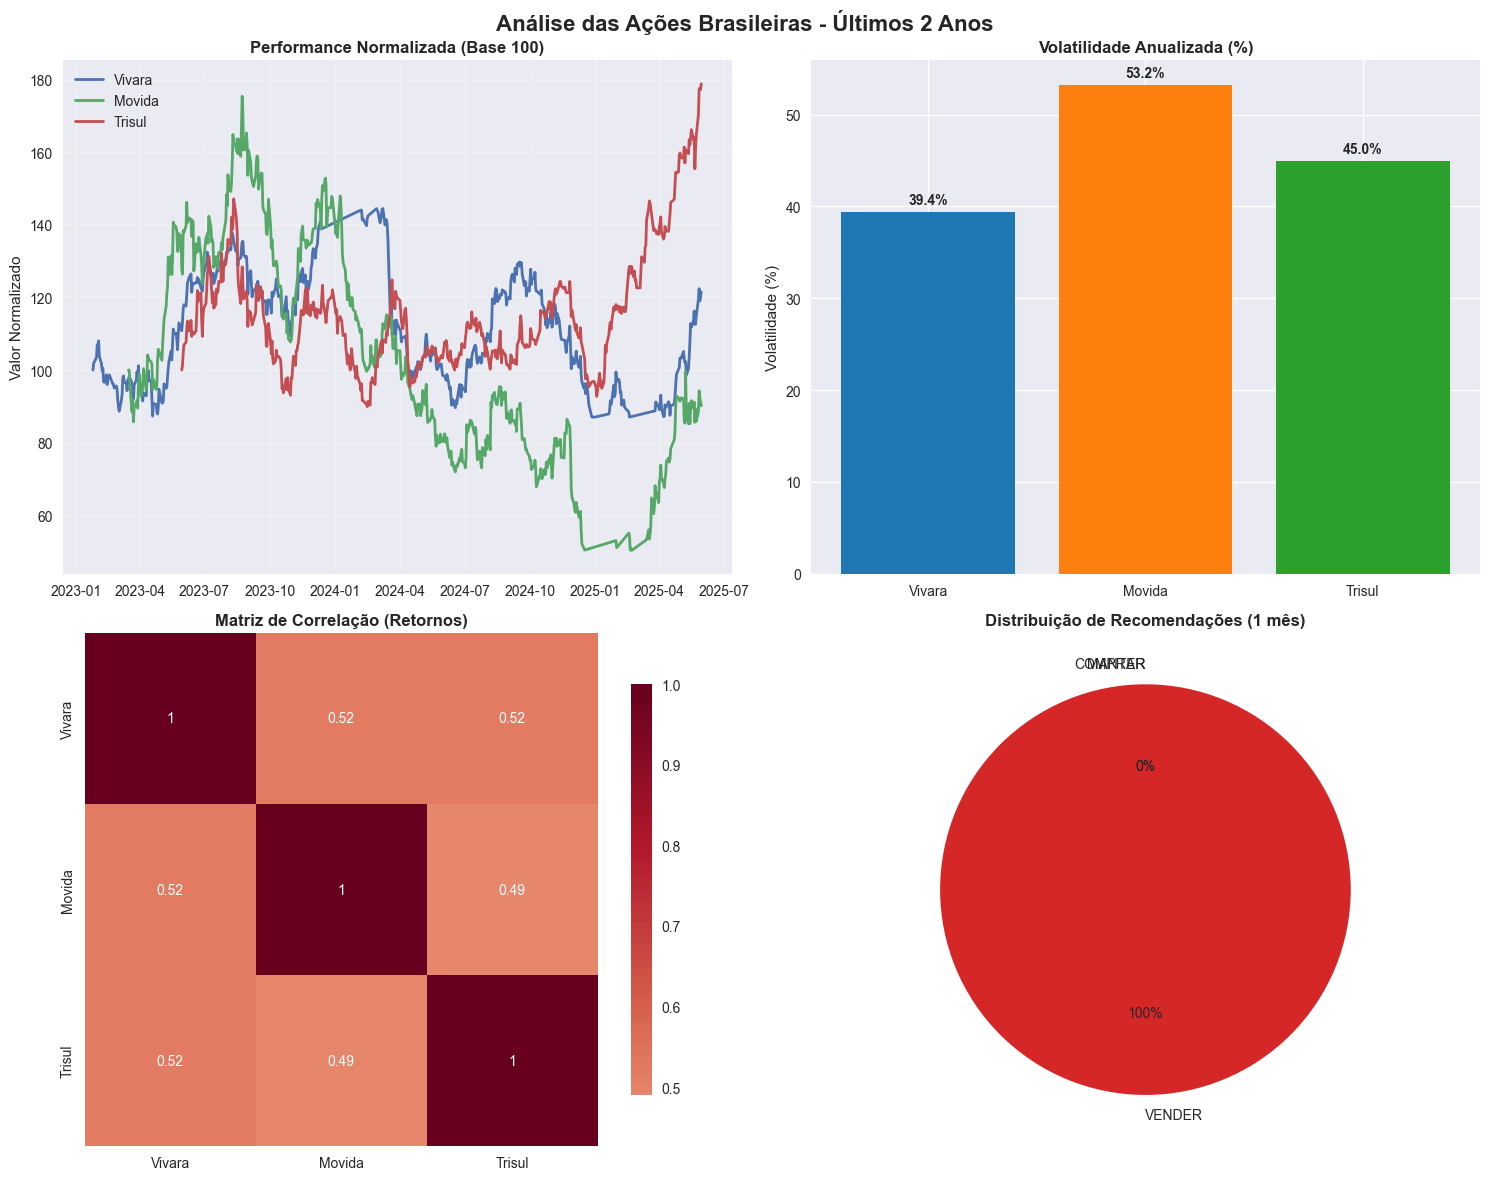

📈 Gráficos gerados com sucesso!


In [16]:
# Criar visualizações dos resultados
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análise das Ações Brasileiras - Últimos 2 Anos', fontsize=16, fontweight='bold')

# Subplot 1: Evolução dos preços
ax1 = axes[0, 0]
for stock, data in stocks_with_indicators.items():
    stock_name = analyzer.data_collector.stock_names[stock]
    recent_data = data.tail(500)  # Últimos 500 dias
    normalized_prices = (recent_data['Close'] / recent_data['Close'].iloc[0]) * 100
    ax1.plot(recent_data.index, normalized_prices, label=stock_name, linewidth=2)

ax1.set_title('Performance Normalizada (Base 100)', fontweight='bold')
ax1.set_ylabel('Valor Normalizado')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Volatilidade
ax2 = axes[0, 1]
volatilities = []
stock_names = []

for stock, data in stocks_with_indicators.items():
    vol = data['Close'].pct_change().std() * np.sqrt(252) * 100
    volatilities.append(vol)
    stock_names.append(analyzer.data_collector.stock_names[stock])

bars = ax2.bar(stock_names, volatilities, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_title('Volatilidade Anualizada (%)', fontweight='bold')
ax2.set_ylabel('Volatilidade (%)')

# Adicionar valores nas barras
for bar, vol in zip(bars, volatilities):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{vol:.1f}%', ha='center', va='bottom', fontweight='bold')

# Subplot 3: Correlação entre ações
ax3 = axes[1, 0]
returns_data = {}
for stock, data in stocks_with_indicators.items():
    returns_data[analyzer.data_collector.stock_names[stock]] = data['Close'].pct_change().dropna()

returns_df = pd.DataFrame(returns_data).dropna()
correlation_matrix = returns_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
           square=True, ax=ax3, cbar_kws={'shrink': 0.8})
ax3.set_title('Matriz de Correlação (Retornos)', fontweight='bold')

# Subplot 4: Distribuição de recomendações
ax4 = axes[1, 1]
recommendations_count = {'COMPRAR': 0, 'MANTER': 0, 'VENDER': 0}

# Contar recomendações para 1 mês
for stock in all_predictions.keys():
    if '1 mês' in all_predictions[stock]:
        rec = all_predictions[stock]['1 mês']['recommendation']
        recommendations_count[rec] += 1

colors = ['#2ca02c', '#ffcc00', '#d62728']
wedges, texts, autotexts = ax4.pie(recommendations_count.values(), 
                                  labels=recommendations_count.keys(),
                                  colors=colors, autopct='%1.0f%%',
                                  startangle=90)
ax4.set_title('Distribuição de Recomendações (1 mês)', fontweight='bold')

plt.tight_layout()
plt.show()

print("📈 Gráficos gerados com sucesso!")

## 10. Análise de Risco e Performance

In [17]:
# Análise detalhada de risco para cada ação
print("\n" + "=" * 80)
print("⚠️  ANÁLISE DE RISCO DETALHADA")
print("=" * 80)

risk_metrics = {}

for stock, data in stocks_with_indicators.items():
    stock_name = analyzer.data_collector.stock_names[stock]
    
    print(f"\n📊 {stock_name} ({stock})")
    print("-" * 50)
    
    # Calcular métricas de risco
    returns = data['Close'].pct_change().dropna()
    
    # VaR 95%
    var_95 = np.percentile(returns, 5) * 100
    
    # Volatilidade anualizada
    volatility = returns.std() * np.sqrt(252) * 100
    
    # Sharpe Ratio (assumindo risk-free rate = 10% anual)
    risk_free_rate = 0.10 / 252
    excess_returns = returns - risk_free_rate
    sharpe_ratio = excess_returns.mean() / returns.std() * np.sqrt(252)
    
    # Maximum Drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    
    # Retorno anualizado
    annual_return = returns.mean() * 252 * 100
    
    risk_metrics[stock] = {
        'var_95': var_95,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'annual_return': annual_return
    }
    
    print(f"  📉 VaR 95%: {var_95:.2f}%")
    print(f"  📊 Volatilidade Anual: {volatility:.2f}%")
    print(f"  ⚖️  Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"  📉 Max Drawdown: {max_drawdown:.2f}%")
    print(f"  📈 Retorno Anual: {annual_return:.2f}%")
    
    # Classificação de risco
    if volatility > 30:
        risk_level = "ALTO 🔴"
    elif volatility > 20:
        risk_level = "MÉDIO 🟡"
    else:
        risk_level = "BAIXO 🟢"
    
    print(f"  🎯 Nível de Risco: {risk_level}")

# Criar tabela comparativa de risco
print("\n" + "=" * 80)
print("📊 TABELA COMPARATIVA DE RISCO")
print("=" * 80)

risk_df_data = []
for stock, metrics in risk_metrics.items():
    stock_name = analyzer.data_collector.stock_names[stock]
    risk_df_data.append({
        'Ação': stock_name,
        'Retorno Anual (%)': f"{metrics['annual_return']:.2f}",
        'Volatilidade (%)': f"{metrics['volatility']:.2f}",
        'Sharpe Ratio': f"{metrics['sharpe_ratio']:.2f}",
        'VaR 95% (%)': f"{metrics['var_95']:.2f}",
        'Max Drawdown (%)': f"{metrics['max_drawdown']:.2f}"
    })

risk_df = pd.DataFrame(risk_df_data)
print(risk_df.to_string(index=False))

print("\n✅ Análise de risco concluída!")


⚠️  ANÁLISE DE RISCO DETALHADA

📊 Vivara (VIVA3.SA)
--------------------------------------------------
  📉 VaR 95%: -3.74%
  📊 Volatilidade Anual: 39.43%
  ⚖️  Sharpe Ratio: 0.12
  📉 Max Drawdown: -39.79%
  📈 Retorno Anual: 14.55%
  🎯 Nível de Risco: ALTO 🔴

📊 Movida (MOVI3.SA)
--------------------------------------------------
  📉 VaR 95%: -5.22%
  📊 Volatilidade Anual: 53.24%
  ⚖️  Sharpe Ratio: -0.12
  📉 Max Drawdown: -77.68%
  📈 Retorno Anual: 3.48%
  🎯 Nível de Risco: ALTO 🔴

📊 Trisul (TRIS3.SA)
--------------------------------------------------
  📉 VaR 95%: -4.44%
  📊 Volatilidade Anual: 44.99%
  ⚖️  Sharpe Ratio: -0.05
  📉 Max Drawdown: -70.21%
  📈 Retorno Anual: 7.76%
  🎯 Nível de Risco: ALTO 🔴

📊 TABELA COMPARATIVA DE RISCO
  Ação Retorno Anual (%) Volatilidade (%) Sharpe Ratio VaR 95% (%) Max Drawdown (%)
Vivara             14.55            39.43         0.12       -3.74           -39.79
Movida              3.48            53.24        -0.12       -5.22           -77.68
Tris

## Conclusão

Este notebook implementou um sistema completo de previsão de ações usando:

1. **Coleta de Dados**: Yahoo Finance API para dados históricos de 5 anos
2. **Análise Técnica**: RSI, MACD, Bollinger Bands, médias móveis e indicadores customizados
3. **Machine Learning**: Redes neurais LSTM com TensorFlow para previsão de preços
4. **Detecção de Eventos**: Identificação automática de grandes movimentos e suas possíveis causas
5. **Sistema de Recomendações**: Algoritmo que combina previsões LSTM com análise técnica
6. **Análise de Risco**: Métricas financeiras completas (VaR, Sharpe Ratio, etc.)
7. **Múltiplos Horizontes**: Previsões para 1 semana, 1 mês, 3 meses, 6 meses e 1 ano

### Principais Features:
- ✅ Análise de **VIVA3, MOVI3 e TRIS3**
- ✅ **Datasets individuais** para cada ação
- ✅ **5 anos de dados históricos**
- ✅ **Detecção de eventos significativos** (grandes altas/baixas)
- ✅ **Recomendações**: COMPRAR, VENDER ou MANTER
- ✅ **Probabilidade de acerto** baseada em dados históricos
- ✅ **Múltiplos horizontes temporais**
- ✅ **Análise de risco completa**

